In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [7]:
import numpy as np
import os
import gzip

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
tf.__version__

'2.0.0'

In [8]:
# 定义加载数据的函数，data_folder为保存gz数据的文件夹，该文件夹下有4个文件
# 'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
# 't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'

def load_data(data_folder):

  files = [
      'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
      't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'
  ]

  paths = []
  for fname in files:
    paths.append(os.path.join(data_folder,fname))

  with gzip.open(paths[0], 'rb') as lbpath:
    y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open(paths[1], 'rb') as imgpath:
    x_train = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

  with gzip.open(paths[2], 'rb') as lbpath:
    y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open(paths[3], 'rb') as imgpath:
    x_test = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

  return (x_train, y_train), (x_test, y_test)

(x_train_all, y_train_all), (x_test, y_test) = load_data('F:\\2、Deep Learning\Tensorflow\Keras_datasets\Fashion-MNIST')
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]
print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

def show_single_image(image_arr):
    plt.imshow(image_arr, cmap='binary')
    plt.show()

def show_images(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)
    plt.figure(figsize=(n_cols * 1.4, n_rows * 1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(x_data[index], cmap='binary', interpolation='nearest')
            plt.axis('off')
            plt.title(class_names[y_data[index]])
    plt.show()

class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# show_single_image(x_train[0])

# show_images(3, 5, x_train, y_train, class_names)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [9]:
# 对数据做归一化  
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train:[None, 28, 28] ->[None, 784] (函数需求)->[None, 28, 28]  归一化要用到除法转为float
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [10]:
def plot_learning_curve(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid()
    plt.ylim(0, 1)
    plt.show()

In [12]:
model =keras.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for i in range(20):
    model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])


In [ ]:
model.summary()

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 12s 222us/sample - loss: 0.5006 - accuracy: 0.8201 - val_loss: 0.4648 - val_accuracy: 0.8450
Epoch 2/100
55000/55000 [==============================] - 12s 224us/sample - loss: 0.4690 - accuracy: 0.8375 - val_loss: 0.4841 - val_accuracy: 0.8464
Epoch 3/100
55000/55000 [==============================] - 12s 224us/sample - loss: 0.4405 - accuracy: 0.8461 - val_loss: 0.4089 - val_accuracy: 0.8638
Epoch 4/100
55000/55000 [==============================] - 12s 224us/sample - loss: 0.4193 - accuracy: 0.8527 - val_loss: 0.4193 - val_accuracy: 0.8602
Epoch 5/100
55000/55000 [==============================] - 12s 222us/sample - loss: 0.4278 - accuracy: 0.8511 - val_loss: 0.4445 - val_accuracy: 0.8468
Epoch 6/100
55000/55000 [==============================] - 12s 221us/sample - loss: 0.4558 - accuracy: 0.8409 - val_loss: 0.5086 - val_accuracy: 0.8346
Epoch 7/100
55000/55000 [==============

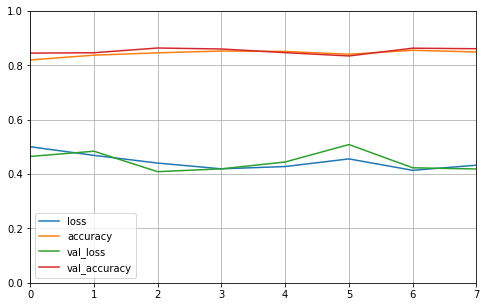

In [16]:
# Tensorboard(文件夹), Earlystopping, ModelCheckpoint(文件名)
logdir = u'.\dnn_callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    # 默认保存最近模型， 改为最好的模型
    # if save_best_only=True, the latest best model according to the quantity monitored will not be overwritten. 
    # If filepath doesn't contain formatting options like {epoch} then filepath will be overwritten by each new better model.
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only='True'),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]

history = model.fit(x_train_scaled, y_train, epochs=100, validation_data=(x_valid_scaled, y_valid),
                   callbacks = callbacks)

# 模型fit完之后 打开anaconda prompt  激活tensorflow环境 输入tensorboard --logdir path
plot_learning_curve(history)

In [17]:
model.evaluate(x_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.43829522519111636, 0.8517]